In [10]:
import pandas as pd
import sys, os, subprocess, shutil, glob, bz2, csv
from Bio import SeqIO
import numpy as np
import json

import logomaker
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
palette = list(mcolors.TABLEAU_COLORS.keys())
%matplotlib inline
#sns.set_theme(style="ticks", palette="pastel")
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")

# Navigate back to workbookDir in case of re-running a code block:
if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
print('workbookDir: ' + workbookDir)
os.chdir(workbookDir)  # If you changed the current working dir, this will take you back to the workbook dir.

workbookDir: /Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq/projects/tRNAseq_lib1/plots/manual_plots


### Requirements
1. gfsa
2. hgrewsa

In [11]:
def freq2ratio(freq):
    return(freq / (1 - freq))

def ratio2freq(ratio):
    return(ratio / (ratio + 1))

In [12]:
# Folders/files:
data_folder = '../../../../data/tRNAseq_lib1'
project_folder = '../../../../projects/tRNAseq_lib1'

plots_data_dir = 'plotting'
data_dir = 'stats_collection'
SWalign_dir = 'SWalign'
sample_list = 'sample_list.xlsx'
alignment_stats = 'alignment_stats.xlsx'
agg_csv_fnam = 'stats_filtered_CC-CCA-aggregate.csv'

In [13]:
### Read sample information ###
sample_df = pd.read_excel(sample_list)

In [14]:
### Read alignment stats ###
align_stat_df = pd.read_excel(data_folder + '/' + SWalign_dir + '/' + alignment_stats)

In [15]:
### Prepare charge dataframe ###

# Skip header lines, if restarted:
with open(data_folder + '/' + data_dir + '/' + agg_csv_fnam, 'r') as fh:
    skip_list = list()
    for idx, l in enumerate(fh):
        if 'sample_name,replicate,barcode,tRNA_annotation' in l:
            skip_list.append(idx)
skip_list.pop(0)
# Load from csv:
df = pd.read_csv(data_folder + '/' + data_dir + '/' + agg_csv_fnam, skiprows=skip_list)
header_mask = (df['count'] != 'count')
df = df[header_mask]
#df['count'] = [int(v) for v in df['count'].values]
df['mito_codon'] = ['mito_tRNA' in anno for anno in df['tRNA_annotation'].values]
df['human_codon'] = ['Homo_sapiens' in anno for anno in df['tRNA_annotation'].values]
df['AA_codon'] = [AA + '-' + codon for codon, AA in zip(df['codon'].values, df['amino_acid'].values)]
# Add sample sheet information:
df = df.merge(sample_df.loc[:, ['sample_name', 'barcode', 'sample_name_unique', 'plot_group', 'hue_name', 'hue_value', 'hue_order']], on=['sample_name', 'barcode'])
# Create single codon filter, to filter out sequences that map to
# tRNA sequences with different codon/anticodon:
single_codon = list()
for anno_str, anticodon in zip(df['tRNA_annotation'].values, df['anticodon'].values):
    sc = True
    anno_list = anno_str.split('@')
    for anno in anno_list:
        if not anno.split('-')[2] == anticodon:
            sc = False
    single_codon.append(sc)
df['single_codon'] = single_codon

# Extract a dataframe for charge data:
dfcol = df.columns.values
col_mask = (dfcol != 'align_3p_nt') & (dfcol != 'count')
cols_sele = dfcol[col_mask]
df_charge = pd.DataFrame(columns=cols_sele)
df_charge['charge'] = []
df_charge['Ncharge'] = []
# Count A/C endings:
df_dict = dict()
for row in df.iterrows():
    key = tuple(row[1].loc[cols_sele])
    if key in df_dict:
        df_dict[key][row[1]['align_3p_nt']] = row[1]['count']
    else:
        df_dict[key] = dict()
        df_dict[key][row[1]['align_3p_nt']] = row[1]['count']
# Add 0 count if count is missing,
# then calculate the charge percentage:
for key in df_dict.keys():
    if 'A' not in df_dict[key]:
        df_dict[key]['A'] = 0
    if 'C' not in df_dict[key]:
        df_dict[key]['C'] = 0
    
    df_dict[key]['charge'] = df_dict[key]['A'] / (df_dict[key]['A'] + df_dict[key]['C']) * 100
    df_dict[key]['Ncharge'] = (df_dict[key]['A'] + df_dict[key]['C'])

# Use a tmp file to write charge
# and total counts for the row (Ncharge),
# then load into dataframe:
try:
    os.remove('tmp_df.csv')
except:
    pass
with open('tmp_df.csv', 'a') as fh_csv:
    df_charge.to_csv(fh_csv, header=True, index=False)
    for i, key in enumerate(df_dict.keys()):
        row = list(key)
        row.append(df_dict[key]['charge'])
        row.append(df_dict[key]['Ncharge'])
        # df_charge.loc[i] = row # Too slow
        print(','.join(map(str, row)), file=fh_csv)
df_charge = pd.read_csv('tmp_df.csv')
os.remove('tmp_df.csv')

# Generate a normalized charge by using the
# E.coli Lys tRNA spike-in.
# This is supposed to correct some of the barcode ligation bias
# leading to more or less CC vs. CCA:
barcodes = set(df_charge['barcode'].values)
charge_norm = dict()
for barcode in barcodes:
    bar_mask = (df_charge['barcode'] == barcode)
    eColi_mask = (df_charge['amino_acid'] == 'eColiLys')
    eColi_charge = df_charge[bar_mask&eColi_mask]['charge'].values.mean()
    charge_norm[barcode] = eColi_charge
max_charge = max(charge_norm.values())
for barcode in barcodes:
    # Convert to a normalizer for ratio:
    charge_norm[barcode] = freq2ratio(max_charge / 100) / freq2ratio(charge_norm[barcode] / 100)
    # charge_norm[barcode] = (100 - max_charge) / (100 - charge_norm[barcode])
df_charge['charge_norm'] = [0] * len(df_charge)
for barcode in barcodes:
    bar_mask = (df_charge['barcode'] == barcode)
    ratio_sele = freq2ratio(df_charge.loc[bar_mask, 'charge'] / 100)
    df_charge.loc[bar_mask, 'charge_norm'] = ratio2freq(ratio_sele * charge_norm[barcode]) * 100
    # df_charge.loc[bar_mask, 'charge_norm'] = 100 - ((100 - df_charge.loc[bar_mask, 'charge']) * charge_norm[barcode])

In [16]:
align_stat_df['sample_name_unique'] = [v[:-29] for v in align_stat_df['Filename'].values]

In [17]:
df_charge = df_charge.merge(align_stat_df.loc[:, ['sample_name_unique', 'Mapping_percent']], on=['sample_name_unique'])

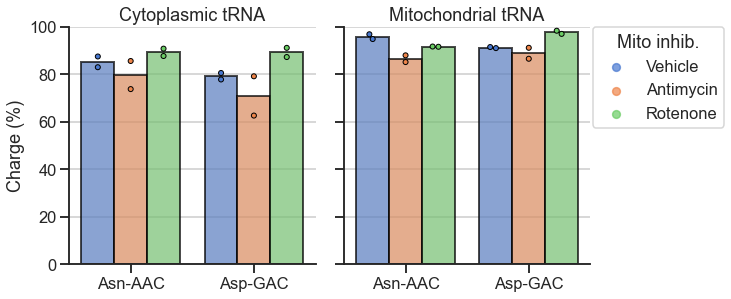

In [10]:
mask = (df_charge['sample_name'] == 'HAV') | (df_charge['sample_name'] == 'HVV') | (df_charge['sample_name'] == 'HR80V')
df_masked = df_charge[mask]
df_masked = df_masked.sort_values('Ncharge').drop_duplicates(['sample_name_unique', 'amino_acid', 'codon', 'mito_codon', 'replicate'], keep='last')


Ngrp = 3
y_axis = 'charge_norm'
legend_labels = ['Vehicle', 'Antimycin', 'Rotenone']
legend_title = 'Mito inhib.'
alpha = 0.7


fig = plt.figure(figsize=(3.5*Ngrp, 4.5))
gs = gridspec.GridSpec(1,2)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)

mask = (df_masked['Ncharge'] > 50) & (~df_masked['mito_codon']) & (df_masked['human_codon']) & ((df_masked['amino_acid'] == 'Asp') | (df_masked['amino_acid'] == 'Asn'))# & (df_masked['Mapping_percent'] > 80) 
hue_order = [t[0] for t in sorted(dict(zip(df_masked[mask]['hue_value'].values, df_masked[mask]['hue_order'].values)).items(), key=lambda x: x[1])]
codon_list = sorted(set(df_masked['AA_codon'][mask].values), key=str.casefold)
g1 = sns.barplot(ax=ax1, x='AA_codon', y=y_axis, order=codon_list, hue='hue_value', hue_order=hue_order, data=df_masked[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=alpha, ci=None)
g1_ = sns.swarmplot(ax=ax1,x='AA_codon', y=y_axis, order=codon_list, hue='hue_value', hue_order=hue_order, data=df_masked[mask], dodge=True, edgecolor='black', linewidth=1)
g1.set_title('Cytoplasmic tRNA')
g1.grid(True, axis='y')
g1.set_ylabel('Charge (%)');
g1.set_xlabel('');
g1.set_ylim(bottom=0, top=100);
g1.set_xticklabels(g1.get_xticklabels(), rotation=0)
g1.legend_.remove()

# mito tRNAs
mask = (df_masked['Ncharge'] > 50)  & (df_masked['mito_codon']) & (df_masked['human_codon']) & ((df_masked['amino_acid'] == 'Asp') | (df_masked['amino_acid'] == 'Asn'))# & (df_masked['Mapping_percent'] > 70) 
codon_list = sorted(set(df_masked['AA_codon'][mask].values), key=str.casefold)
g2 = sns.barplot(ax=ax2, x='AA_codon', y=y_axis, order=codon_list, hue='hue_value', hue_order=hue_order, data=df_masked[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=alpha, ci=None)
g2 = sns.swarmplot(ax=ax2, x='AA_codon', y=y_axis, order=codon_list, hue='hue_value', hue_order=hue_order, data=df_masked[mask], dodge=True, edgecolor='black', linewidth=1)
g2.set_title('Mitochondrial tRNA')
g2.grid(True, axis='y')
g2.set_ylabel('');
g2.set_xlabel('');
g2.set_ylim(bottom=0, top=100);
g2.set_xticklabels(g2.get_xticklabels(), rotation=0)
old_legend = g2.legend_
handles = old_legend.legendHandles
#labels = hue_order
#title = df_masked[mask]['hue_name'].values[0]
for lh in handles:
    lh.set_alpha(alpha)
g2.legend(handles, legend_labels, title=legend_title, bbox_to_anchor=(1.01,1), borderaxespad=0)


sns.despine()
plt.tight_layout()
fig.savefig('H1299_mito-inhib_Asp-Asn.pdf')
#fig.clear()
#g1.clear()
#g2.clear()

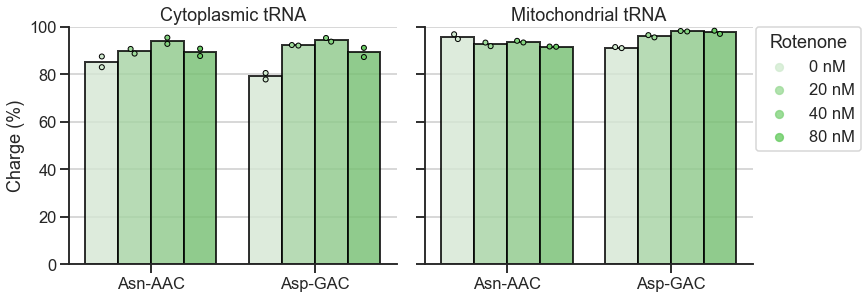

In [22]:
mask = (df_charge['sample_name'] == 'HVV') | (df_charge['sample_name'] == 'HR20V') | (df_charge['sample_name'] == 'HR40V') | (df_charge['sample_name'] == 'HR80V')
df_masked = df_charge[mask]
df_masked = df_masked.sort_values('Ncharge').drop_duplicates(['sample_name_unique', 'amino_acid', 'codon', 'mito_codon', 'replicate'], keep='last')


green_palette = sns.light_palette(sns.color_palette()[2])
green_palette = [green_palette[1], green_palette[3], green_palette[4], green_palette[-1]]

Ngrp = 4
y_axis = 'charge_norm'
alpha = 0.8
legend_labels = ['0 nM', '20 nM', '40 nM', '80 nM']
legend_title = 'Rotenone'

fig = plt.figure(figsize=(3.1*Ngrp, 4.5))
gs = gridspec.GridSpec(1,2)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)


mask = (df_masked['Ncharge'] > 50) & (~df_masked['mito_codon']) & (df_masked['human_codon']) & ((df_masked['amino_acid'] == 'Asp') | (df_masked['amino_acid'] == 'Asn'))# & (df_masked['Mapping_percent'] > 80) 
hue_order = [t[0] for t in sorted(dict(zip(df_masked[mask]['hue_value'].values, df_masked[mask]['hue_order'].values)).items(), key=lambda x: x[1])]
codon_list = sorted(set(df_masked['AA_codon'][mask].values), key=str.casefold)
g1 = sns.barplot(ax=ax1, x='AA_codon', y=y_axis, order=codon_list, hue='hue_value', hue_order=hue_order, data=df_masked[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=alpha, ci=None, palette=green_palette)
g1_ = sns.swarmplot(ax=ax1,x='AA_codon', y=y_axis, order=codon_list, hue='hue_value', hue_order=hue_order, data=df_masked[mask], dodge=True, edgecolor='black', linewidth=1, palette=green_palette)
g1.set_title('Cytoplasmic tRNA')
g1.grid(True, axis='y')
g1.set_ylabel('Charge (%)');
g1.set_xlabel('');
g1.set_ylim(bottom=0, top=100);
g1.set_xticklabels(g1.get_xticklabels(), rotation=0)
g1.legend_.remove()

# mito tRNAs
mask = (df_masked['Ncharge'] > 50)  & (df_masked['mito_codon']) & (df_masked['human_codon']) & ((df_masked['amino_acid'] == 'Asp') | (df_masked['amino_acid'] == 'Asn'))# & (df_masked['Mapping_percent'] > 70) 
codon_list = sorted(set(df_masked['AA_codon'][mask].values), key=str.casefold)
g2 = sns.barplot(ax=ax2, x='AA_codon', y=y_axis, order=codon_list, hue='hue_value', hue_order=hue_order, data=df_masked[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=alpha, ci=None, palette=green_palette)
g2 = sns.swarmplot(ax=ax2, x='AA_codon', y=y_axis, order=codon_list, hue='hue_value', hue_order=hue_order, data=df_masked[mask], dodge=True, edgecolor='black', linewidth=1, palette=green_palette)
g2.set_title('Mitochondrial tRNA')
g2.grid(True, axis='y')
g2.set_ylabel('');
g2.set_xlabel('');
g2.set_ylim(bottom=0, top=100);
g2.set_xticklabels(g2.get_xticklabels(), rotation=0)
old_legend = g2.legend_
handles = old_legend.legendHandles
labels = hue_order
#title = df_masked[mask]['hue_name'].values[0]
for lh in handles:
    lh.set_alpha(alpha)
g2.legend(handles, legend_labels, title=legend_title, bbox_to_anchor=(1.01,1), borderaxespad=0)


sns.despine()
plt.tight_layout()
fig.savefig('H1299_rot-tit_Asp-Asn.pdf')
#fig.clear()
#g1.clear()
#g2.clear()

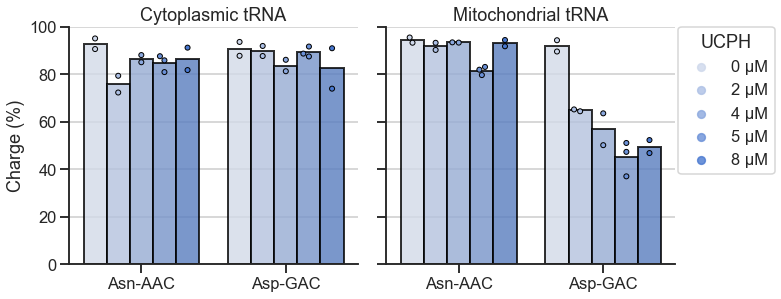

In [12]:
mask = (df_charge['sample_name'] == '0U') | (df_charge['sample_name'] == '2U') | (df_charge['sample_name'] == '4U') | (df_charge['sample_name'] == 'U') | (df_charge['sample_name'] == '8U')
df_masked = df_charge[mask]
df_masked = df_masked.sort_values('Ncharge').drop_duplicates(['sample_name_unique', 'amino_acid', 'codon', 'mito_codon', 'replicate'], keep='last')


green_palette = sns.color_palette("light:b")
green_palette = [green_palette[1], green_palette[2], green_palette[3],  green_palette[4], green_palette[-1]]

Ngrp = 4
y_axis = 'charge'
alpha = 0.8
legend_labels = ['0 μM', '2 μM', '4 μM', '5 μM', '8 μM']
legend_title = 'UCPH'

fig = plt.figure(figsize=(2.8*Ngrp, 4.5))
gs = gridspec.GridSpec(1,2)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)


mask = (df_masked['Ncharge'] > 50) & (~df_masked['mito_codon']) & (df_masked['human_codon']) & ((df_masked['amino_acid'] == 'Asp') | (df_masked['amino_acid'] == 'Asn'))# & (df_masked['Mapping_percent'] > 80) 
hue_order = [t[0] for t in sorted(dict(zip(df_masked[mask]['hue_value'].values, df_masked[mask]['hue_order'].values)).items(), key=lambda x: x[1])]
codon_list = sorted(set(df_masked['AA_codon'][mask].values), key=str.casefold)
g1 = sns.barplot(ax=ax1, x='AA_codon', y=y_axis, order=codon_list, hue='hue_value', hue_order=hue_order, data=df_masked[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=alpha, ci=None, palette=green_palette)
g1_ = sns.swarmplot(ax=ax1,x='AA_codon', y=y_axis, order=codon_list, hue='hue_value', hue_order=hue_order, data=df_masked[mask], dodge=True, edgecolor='black', linewidth=1, palette=green_palette)
g1.set_title('Cytoplasmic tRNA')
g1.grid(True, axis='y')
g1.set_ylabel('Charge (%)');
g1.set_xlabel('');
g1.set_ylim(bottom=0, top=100);
g1.set_xticklabels(g1.get_xticklabels(), rotation=0)
g1.legend_.remove()

# mito tRNAs
mask = (df_masked['Ncharge'] > 50)  & (df_masked['mito_codon']) & (df_masked['human_codon']) & ((df_masked['amino_acid'] == 'Asp') | (df_masked['amino_acid'] == 'Asn'))# & (df_masked['Mapping_percent'] > 70) 
codon_list = sorted(set(df_masked['AA_codon'][mask].values), key=str.casefold)
g2 = sns.barplot(ax=ax2, x='AA_codon', y=y_axis, order=codon_list, hue='hue_value', hue_order=hue_order, data=df_masked[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=alpha, ci=None, palette=green_palette)
g2 = sns.swarmplot(ax=ax2, x='AA_codon', y=y_axis, order=codon_list, hue='hue_value', hue_order=hue_order, data=df_masked[mask], dodge=True, edgecolor='black', linewidth=1, palette=green_palette)
g2.set_title('Mitochondrial tRNA')
g2.grid(True, axis='y')
g2.set_ylabel('');
g2.set_xlabel('');
g2.set_ylim(bottom=0, top=100);
g2.set_xticklabels(g2.get_xticklabels(), rotation=0)
old_legend = g2.legend_
handles = old_legend.legendHandles
#labels = hue_order
#title = df_masked[mask]['hue_name'].values[0]
for lh in handles:
    lh.set_alpha(alpha)
g2.legend(handles, legend_labels, title=legend_title, bbox_to_anchor=(1.01,1), borderaxespad=0)


sns.despine()
plt.tight_layout()
fig.savefig('GOT-DKO_UCPH-tit_Asp-Asn.pdf')
#fig.clear()
#g1.clear()
#g2.clear()

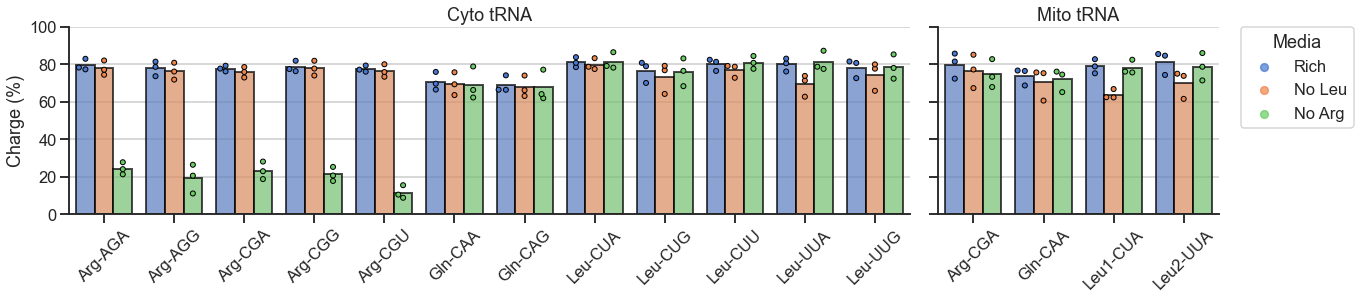

In [13]:
mask = (df_charge['plot_group'] == 'Pilot-exp')
df_masked = df_charge[mask]
df_masked = df_masked.sort_values('Ncharge').drop_duplicates(['sample_name_unique', 'amino_acid', 'codon', 'mito_codon', 'replicate'], keep='last')


Ngrp = 4
y_axis = 'charge_norm'
legend_title = 'Media'
alpha = 0.7


fig = plt.figure(figsize=(4.8*Ngrp, 4.5))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)

mask = (df_masked['Ncharge'] > 50) & (~df_masked['mito_codon']) & (df_masked['human_codon']) & ((df_masked['amino_acid'] == 'Arg') | (df_masked['amino_acid'] == 'Leu') | (df_masked['amino_acid'] == 'Leu1') | (df_masked['amino_acid'] == 'Leu2') | (df_masked['amino_acid'] == 'Gln'))# & (df_masked['Mapping_percent'] > 80) 
hue_order = [t[0] for t in sorted(dict(zip(df_masked[mask]['hue_value'].values, df_masked[mask]['hue_order'].values)).items(), key=lambda x: x[1])]
codon_list = sorted(set(df_masked['AA_codon'][mask].values), key=str.casefold)
g1 = sns.barplot(ax=ax1, x='AA_codon', y=y_axis, order=codon_list, hue='hue_value', hue_order=hue_order, data=df_masked[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=alpha, ci=None)
g1_ = sns.swarmplot(ax=ax1,x='AA_codon', y=y_axis, order=codon_list, hue='hue_value', hue_order=hue_order, data=df_masked[mask], dodge=True, edgecolor='black', linewidth=1)
g1.set_title('Cyto tRNA')
g1.grid(True, axis='y')
g1.set_ylabel('Charge (%)');
g1.set_xlabel('');
g1.set_ylim(bottom=0, top=100);
g1.set_xticklabels(g1.get_xticklabels(), rotation=45)
g1.legend_.remove()

# mito tRNAs
mask = (df_masked['Ncharge'] > 50)  & (df_masked['mito_codon']) & (df_masked['human_codon']) & ((df_masked['amino_acid'] == 'Arg') | (df_masked['amino_acid'] == 'Leu') | (df_masked['amino_acid'] == 'Leu1') | (df_masked['amino_acid'] == 'Leu2') | (df_masked['amino_acid'] == 'Gln'))# & (df_masked['Mapping_percent'] > 70) 
codon_list = sorted(set(df_masked['AA_codon'][mask].values), key=str.casefold)
g2 = sns.barplot(ax=ax2, x='AA_codon', y=y_axis, order=codon_list, hue='hue_value', hue_order=hue_order, data=df_masked[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=alpha, ci=None)
g2 = sns.swarmplot(ax=ax2, x='AA_codon', y=y_axis, order=codon_list, hue='hue_value', hue_order=hue_order, data=df_masked[mask], dodge=True, edgecolor='black', linewidth=1)
g2.set_title('Mito tRNA')
g2.grid(True, axis='y')
g2.set_ylabel('');
g2.set_xlabel('');
g2.set_ylim(bottom=0, top=100);
g2.set_xticklabels(g2.get_xticklabels(), rotation=45)
old_legend = g2.legend_
handles = old_legend.legendHandles
labels = hue_order
#title = df_masked[mask]['hue_name'].values[0]
for lh in handles:
    lh.set_alpha(alpha)
g2.legend(handles, labels, title=legend_title, bbox_to_anchor=(1.08, 1), borderaxespad=0)


sns.despine()
plt.tight_layout()
fig.savefig('pilot-test_Arg-Leu-Gln.pdf')
#fig.clear()
#g1.clear()
#g2.clear()

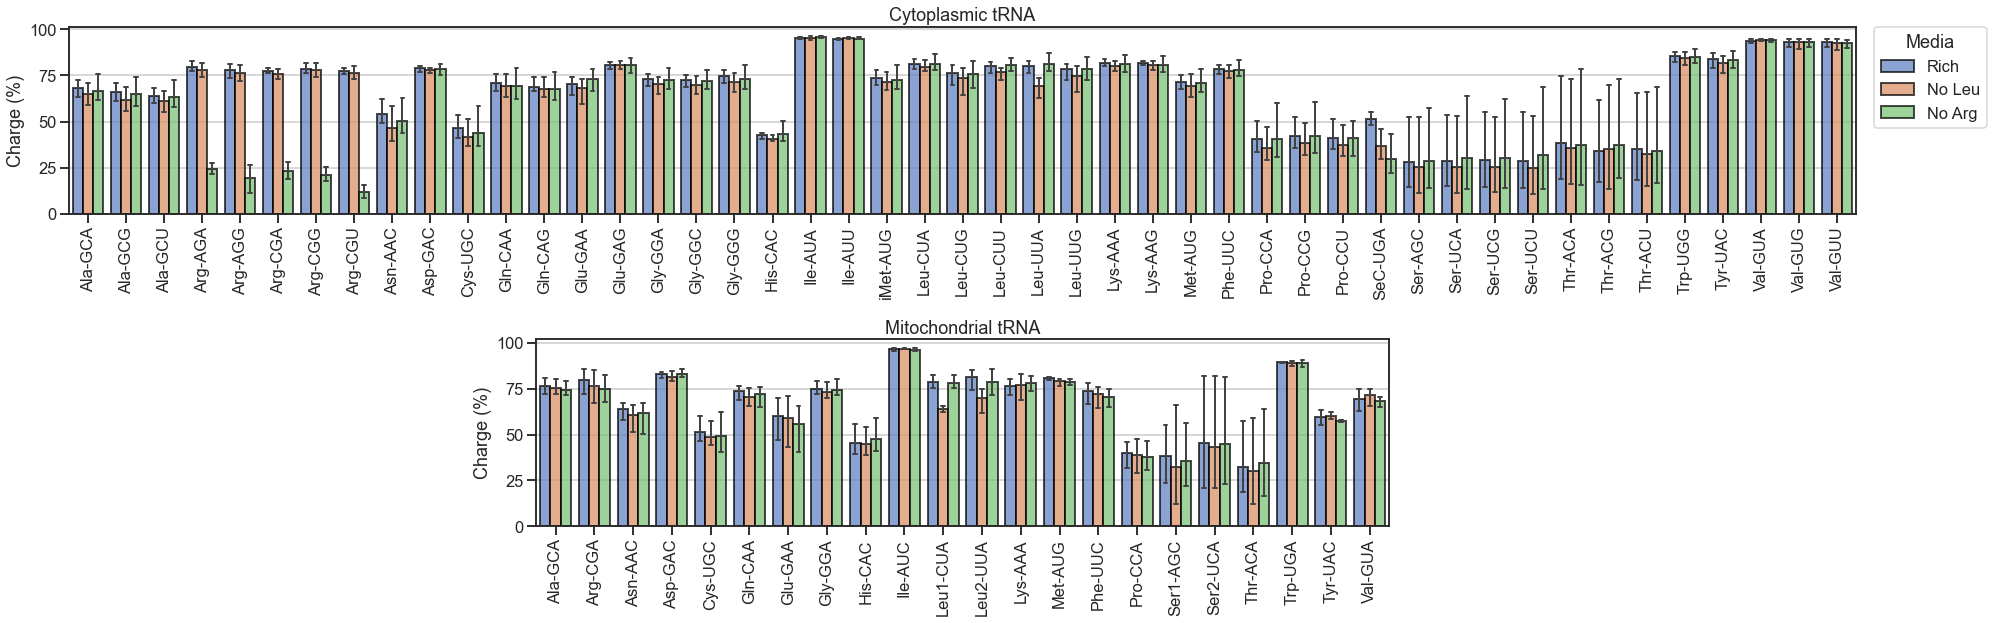

In [14]:
mask = (df_charge['plot_group'] == 'Pilot-exp')
df_masked = df_charge[mask]
df_masked = df_masked.sort_values('Ncharge').drop_duplicates(['sample_name_unique', 'amino_acid', 'codon', 'mito_codon', 'replicate'], keep='last')

Ngrp = 3
y_axis = 'charge_norm'
legend_title = 'Media'

fig = plt.figure(figsize=(28/3*Ngrp, 9))
gs = fig.add_gridspec(2, 4)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 1:3])

# Cyto tRNAs
mask = (df_masked['Ncharge'] > 50) & (~df_masked['mito_codon']) & (df_masked['human_codon'])
hue_order = [t[0] for t in sorted(dict(zip(df_masked[mask]['hue_value'].values, df_masked[mask]['hue_order'].values)).items(), key=lambda x: x[1])]

codon_list = sorted(set(df_masked['AA_codon'][mask].values), key=str.casefold)
g1 = sns.barplot(ax=ax1, x='AA_codon', y='charge_norm', order=codon_list, hue='hue_value', hue_order=hue_order, data=df_masked[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
g1.set_title('Cytoplasmic tRNA')
g1.grid(True, axis='y')
g1.set_ylabel('Charge (%)');
g1.set_xlabel('');
g1.set_xticklabels(g1.get_xticklabels(), rotation=90)
old_legend = g1.legend_
handles = old_legend.legendHandles
labels = hue_order
title = df_masked[mask]['hue_name'].values[0]
g1.legend(handles, labels, title=legend_title, bbox_to_anchor=(1.01, 1), borderaxespad=0)

# mito tRNAs
mask = (df_masked['Ncharge'] > 50)  & (df_masked['mito_codon']) & (df_masked['human_codon'])
codon_list = sorted(set(df_masked['AA_codon'][mask].values), key=str.casefold)
g2 = sns.barplot(ax=ax2, x='AA_codon', y='charge_norm', order=codon_list, hue='hue_value', hue_order=hue_order, data=df_masked[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
g2.set_title('Mitochondrial tRNA')
g2.grid(True, axis='y')
g2.set_ylabel('Charge (%)');
g2.set_xlabel('');
g2.set_xticklabels(g2.get_xticklabels(), rotation=90)
g2.legend_.remove()

plt.tight_layout()
fig.savefig('pilot-test_all.pdf')
#fig.clear()
#g1.clear()
#g2.clear()


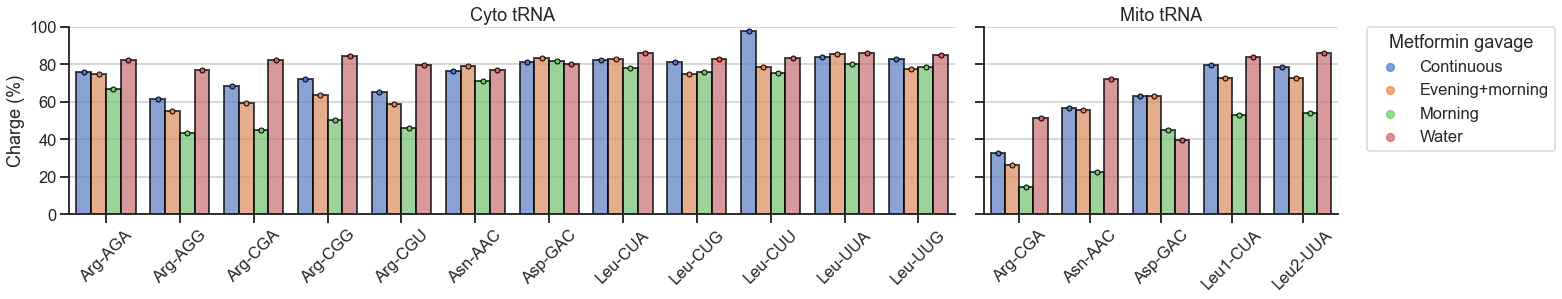

In [15]:
mask = (df_charge['plot_group'] == 'Liver-tissue')
df_masked = df_charge[mask]
df_masked = df_masked.sort_values('Ncharge').drop_duplicates(['sample_name_unique', 'amino_acid', 'codon', 'mito_codon', 'replicate'], keep='last')


Ngrp = 4
y_axis = 'charge_norm'
legend_title = 'Metformin gavage'
legend_labels = ['Continuous', 'Evening+morning', 'Morning', 'Water']
alpha = 0.7


fig = plt.figure(figsize=(5.5*Ngrp, 4.5))
gs = gridspec.GridSpec(1, 2, width_ratios=[2.5, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)

mask = (df_masked['Ncharge'] > 50) & (~df_masked['mito_codon']) & ((df_masked['amino_acid'] == 'Arg') | (df_masked['amino_acid'] == 'Leu') | (df_masked['amino_acid'] == 'Leu1') | (df_masked['amino_acid'] == 'Leu2') | (df_masked['amino_acid'] == 'Asp') | (df_masked['amino_acid'] == 'Asn'))# & (df_masked['Mapping_percent'] > 80)
hue_order = [t[0] for t in sorted(dict(zip(df_masked[mask]['hue_value'].values, df_masked[mask]['hue_order'].values)).items(), key=lambda x: x[1])]
codon_list = sorted(set(df_masked['AA_codon'][mask].values), key=str.casefold)
g1 = sns.barplot(ax=ax1, x='AA_codon', y=y_axis, order=codon_list, hue='hue_value', hue_order=hue_order, data=df_masked[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=alpha, ci=None)
g1_ = sns.swarmplot(ax=ax1,x='AA_codon', y=y_axis, order=codon_list, hue='hue_value', hue_order=hue_order, data=df_masked[mask], dodge=True, edgecolor='black', linewidth=1)
g1.set_title('Cyto tRNA')
g1.grid(True, axis='y')
g1.set_ylabel('Charge (%)');
g1.set_xlabel('');
g1.set_ylim(bottom=0, top=100);
g1.set_xticklabels(g1.get_xticklabels(), rotation=45)
g1.legend_.remove()

# mito tRNAs
mask = (df_masked['Ncharge'] > 50)  & (df_masked['mito_codon']) & ((df_masked['amino_acid'] == 'Arg') | (df_masked['amino_acid'] == 'Leu') | (df_masked['amino_acid'] == 'Leu1') | (df_masked['amino_acid'] == 'Leu2') | (df_masked['amino_acid'] == 'Asp') | (df_masked['amino_acid'] == 'Asn'))# & (df_masked['Mapping_percent'] > 70) 
codon_list = sorted(set(df_masked['AA_codon'][mask].values), key=str.casefold)
g2 = sns.barplot(ax=ax2, x='AA_codon', y=y_axis, order=codon_list, hue='hue_value', hue_order=hue_order, data=df_masked[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=alpha, ci=None)
g2 = sns.swarmplot(ax=ax2, x='AA_codon', y=y_axis, order=codon_list, hue='hue_value', hue_order=hue_order, data=df_masked[mask], dodge=True, edgecolor='black', linewidth=1)
g2.set_title('Mito tRNA')
g2.grid(True, axis='y')
g2.set_ylabel('');
g2.set_xlabel('');
g2.set_ylim(bottom=0, top=100);
g2.set_xticklabels(g2.get_xticklabels(), rotation=45)
old_legend = g2.legend_
handles = old_legend.legendHandles
labels = hue_order
#title = df_masked[mask]['hue_name'].values[0]
for lh in handles:
    lh.set_alpha(alpha)
g2.legend(handles, legend_labels, title=legend_title, bbox_to_anchor=(1.08, 1), borderaxespad=0)


sns.despine()
plt.tight_layout()
fig.savefig('mouse-metformin_liver-Arg-Leu-Gln.pdf')
#fig.clear()
#g1.clear()
#g2.clear()

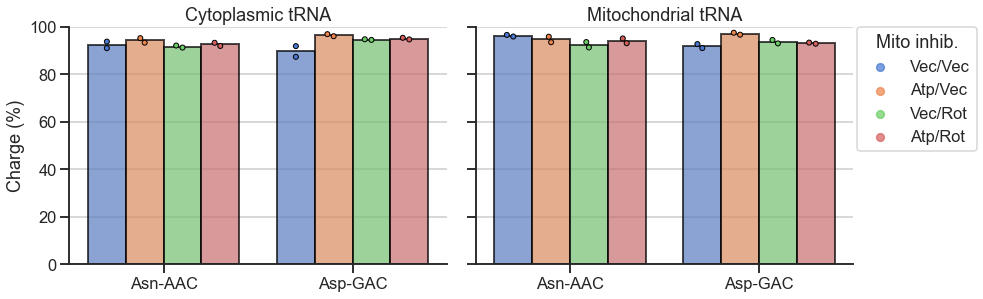

In [16]:
mask = (df_charge['plot_group'] == 'Atpenin-rescue')
df_masked = df_charge[mask]
df_masked = df_masked.sort_values('Ncharge').drop_duplicates(['sample_name_unique', 'amino_acid', 'codon', 'mito_codon', 'replicate'], keep='last')


Ngrp = 4
y_axis = 'charge_norm'
legend_labels = ['Vec/Vec', 'Atp/Vec', 'Vec/Rot', 'Atp/Rot']
legend_title = 'Mito inhib.'
alpha = 0.7


fig = plt.figure(figsize=(3.5*Ngrp, 4.5))
gs = gridspec.GridSpec(1,2)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)

mask = (df_masked['Ncharge'] > 50) & (~df_masked['mito_codon']) & (df_masked['human_codon']) & ((df_masked['amino_acid'] == 'Asp') | (df_masked['amino_acid'] == 'Asn'))# & (df_masked['Mapping_percent'] > 80) 
hue_order = [t[0] for t in sorted(dict(zip(df_masked[mask]['hue_value'].values, df_masked[mask]['hue_order'].values)).items(), key=lambda x: x[1])]
codon_list = sorted(set(df_masked['AA_codon'][mask].values), key=str.casefold)
g1 = sns.barplot(ax=ax1, x='AA_codon', y=y_axis, order=codon_list, hue='hue_value', hue_order=hue_order, data=df_masked[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=alpha, ci=None)
g1_ = sns.swarmplot(ax=ax1,x='AA_codon', y=y_axis, order=codon_list, hue='hue_value', hue_order=hue_order, data=df_masked[mask], dodge=True, edgecolor='black', linewidth=1)
g1.set_title('Cytoplasmic tRNA')
g1.grid(True, axis='y')
g1.set_ylabel('Charge (%)');
g1.set_xlabel('');
g1.set_ylim(bottom=0, top=100);
g1.set_xticklabels(g1.get_xticklabels(), rotation=0)
g1.legend_.remove()

# mito tRNAs
mask = (df_masked['Ncharge'] > 50)  & (df_masked['mito_codon']) & (df_masked['human_codon']) & ((df_masked['amino_acid'] == 'Asp') | (df_masked['amino_acid'] == 'Asn'))# & (df_masked['Mapping_percent'] > 70) 
codon_list = sorted(set(df_masked['AA_codon'][mask].values), key=str.casefold)
g2 = sns.barplot(ax=ax2, x='AA_codon', y=y_axis, order=codon_list, hue='hue_value', hue_order=hue_order, data=df_masked[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=alpha, ci=None)
g2 = sns.swarmplot(ax=ax2, x='AA_codon', y=y_axis, order=codon_list, hue='hue_value', hue_order=hue_order, data=df_masked[mask], dodge=True, edgecolor='black', linewidth=1)
g2.set_title('Mitochondrial tRNA')
g2.grid(True, axis='y')
g2.set_ylabel('');
g2.set_xlabel('');
g2.set_ylim(bottom=0, top=100);
g2.set_xticklabels(g2.get_xticklabels(), rotation=0)
old_legend = g2.legend_
handles = old_legend.legendHandles
#labels = hue_order
#title = df_masked[mask]['hue_name'].values[0]
for lh in handles:
    lh.set_alpha(alpha)
g2.legend(handles, legend_labels, title=legend_title, bbox_to_anchor=(1.01,1), borderaxespad=0)


sns.despine()
plt.tight_layout()
fig.savefig('143B-atpenin-rescue_Asp-Asn.pdf')
#fig.clear()
#g1.clear()
#g2.clear()

In [10]:
### Per sample charge plots ###

# No normalization
per_sample_plots_dir = 'per_sample_charge'
try:
    os.mkdir(per_sample_plots_dir)
except:
    if CLEAN_DIR:
        shutil.rmtree(per_sample_plots_dir)
        os.mkdir(per_sample_plots_dir)
    else:
        pass

sample_names = set(df_charge['sample_name'].values)
for sample_name in sample_names:

    fig = plt.figure(figsize=(20, 9))
    gs = fig.add_gridspec(2, 4)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 1:3])

    # Cyto tRNAs
    mask = (df_charge['sample_name'] == sample_name) & (df_charge['human_codon']) & (~df_charge['mito_codon']) & (df_charge['Ncharge'] > 50) & (df_charge['single_codon'])
    codon_list = sorted(set(df_charge['AA_codon'][mask].values), key=str.casefold)
    g1 = sns.barplot(ax=ax1, x='AA_codon', y='charge', order=codon_list, data=df_charge[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
    g1.set_title('Cytoplasmic tRNA')
    g1.grid(True, axis='y')
    g1.set_ylabel('Charge (%)');
    g1.set_xlabel('');
    g1.set_xticklabels(g1.get_xticklabels(), rotation=90)

    # mito tRNAs
    mask = (df_charge['sample_name'] == sample_name) & (df_charge['human_codon']) & (df_charge['mito_codon']) & (df_charge['Ncharge'] > 50) & (df_charge['single_codon'])
    codon_list = sorted(set(df_charge['AA_codon'][mask].values), key=str.casefold)
    g2 = sns.barplot(ax=ax2, x='AA_codon', y='charge', order=codon_list, data=df_charge[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
    g2.set_title('Mitochondrial tRNA')
    g2.grid(True, axis='y')
    g2.set_ylabel('Charge (%)');
    g2.set_xlabel('');
    g2.set_xticklabels(g2.get_xticklabels(), rotation=90)

    plt.tight_layout()
    fig.savefig('{}/{}.pdf'.format(per_sample_plots_dir, sample_name))
    fig.clear()
    g1.clear()
    g2.clear()

    # Per transcript charge
    fig, ax1 = plt.subplots(1, 1, figsize=(40, 10))
    mask = (df_charge['sample_name'] == sample_name) & (df_charge['human_codon']) & (df_charge['Ncharge'] > 50) & (df_charge['unique_annotation'])
    anno_list = sorted(set(df_charge['tRNA_annotation'][mask].values), key=str.casefold)
    # Make color cycle for same codons:
    anno2codon = {a: c for a, c in zip(df_charge['tRNA_annotation'][mask].values, df_charge['AA_codon'][mask].values)}
    cmap = sns.color_palette(None, len(anno_list))
    codons = sorted(set(df_charge[mask]['AA_codon'].values), key=str.casefold)
    codon2color = {nam: cmap[i] for i, nam in enumerate(codons)}
    palette = {a: codon2color[anno2codon[a]] for a in df_charge['tRNA_annotation'][mask].values}
    g1 = sns.barplot(ax=ax1, x='tRNA_annotation', y='charge', palette=palette, order=anno_list, data=df_charge[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
    g1.grid(True, axis='y')
    g1.set_ylabel('Charge (%)');
    g1.set_xlabel('');
    g1.set_xticklabels(g1.get_xticklabels(), rotation=90)
    plt.tight_layout()
    fig.savefig('{}/transcripts_{}.pdf'.format(per_sample_plots_dir, sample_name))
    fig.clear()
    g1.clear()
    
#### Barcode bias ####
fig = plt.figure(figsize=(40, 9))
gs = fig.add_gridspec(2, 4)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 1:3])

# Cyto tRNAs
mask = (~df_charge['mito_codon']) & (df_charge['Ncharge'] > 50) & (df_charge['single_codon'])
codon_list = sorted(set(df_charge['AA_codon'][mask].values), key=str.casefold)
codon_list.pop(codon_list.index('eColiLys-AAA'))
codon_list = ['eColiLys-AAA'] + codon_list
g1 = sns.barplot(ax=ax1, x='AA_codon', y='charge', order=codon_list, hue_order=['l1', 'l2', 'l3', 'l4'], hue='barcode', data=df_charge[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
g1.set_title('Cytoplasmic tRNA')
g1.grid(True, axis='y')
g1.set_ylabel('Charge (%)');
g1.set_xlabel('');
g1.set_xticklabels(g1.get_xticklabels(), rotation=90)

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = ['l1', 'l2', 'l3', 'l4']
title = 'Barcode'
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04,1), borderaxespad=0)

# mito tRNAs
mask = (df_charge['mito_codon']) & (df_charge['Ncharge'] > 50) & (df_charge['single_codon'])
codon_list = sorted(set(df_charge['AA_codon'][mask].values), key=str.casefold)
g2 = sns.barplot(ax=ax2, x='AA_codon', y='charge', order=codon_list, hue_order=['l1', 'l2', 'l3', 'l4'], hue='barcode', data=df_charge[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
g2.set_title('Mitochondrial tRNA')
g2.grid(True, axis='y')
g2.set_ylabel('Charge (%)');
g2.set_xlabel('');
g2.set_xticklabels(g2.get_xticklabels(), rotation=90)

old_legend = g2.legend_
handles = old_legend.legendHandles
labels = ['l1', 'l2', 'l3', 'l4']
title = 'Barcode'
g2.legend(handles, labels, title=title, bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.tight_layout()
fig.savefig('{}/barcode-bias_codon-breakdown.pdf'.format(per_sample_plots_dir))
fig.clear()
g1.clear()
g2.clear()

# All tRNAs
fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))
g1 = sns.barplot(ax=ax1, x='barcode', y='charge', order=['l1', 'l2', 'l3', 'l4'], data=df_charge, capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
g1.set_title('All tRNA')
g1.grid(True, axis='y')
g1.set_ylabel('Charge (%)');
g1.set_xlabel('');
plt.tight_layout()
fig.savefig('{}/barcode-bias_all-tRNAs.pdf'.format(per_sample_plots_dir))
fig.clear()
g1.clear()





# Normalized by E.coli Lys spike-in
per_sample_plots_dir = 'per_sample_charge_norm'
try:
    os.mkdir(per_sample_plots_dir)
except:
    if CLEAN_DIR:
        shutil.rmtree(per_sample_plots_dir)
        os.mkdir(per_sample_plots_dir)
    else:
        pass

sample_names = set(df_charge['sample_name'].values)
for sample_name in sample_names:

    fig = plt.figure(figsize=(20, 9))
    gs = fig.add_gridspec(2, 4)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 1:3])

    # Cyto tRNAs
    mask = (df_charge['sample_name'] == sample_name) & (df_charge['human_codon']) & (~df_charge['mito_codon']) & (df_charge['Ncharge'] > 50) & (df_charge['single_codon'])
    codon_list = sorted(set(df_charge['AA_codon'][mask].values), key=str.casefold)
    g1 = sns.barplot(ax=ax1, x='AA_codon', y='charge_norm', order=codon_list, data=df_charge[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
    g1.set_title('Cytoplasmic tRNA')
    g1.grid(True, axis='y')
    g1.set_ylabel('Charge (%)');
    g1.set_xlabel('');
    g1.set_xticklabels(g1.get_xticklabels(), rotation=90)

    # mito tRNAs
    mask = (df_charge['sample_name'] == sample_name) & (df_charge['human_codon']) & (df_charge['mito_codon']) & (df_charge['Ncharge'] > 50) & (df_charge['single_codon'])
    codon_list = sorted(set(df_charge['AA_codon'][mask].values), key=str.casefold)
    g2 = sns.barplot(ax=ax2, x='AA_codon', y='charge_norm', order=codon_list, data=df_charge[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
    g2.set_title('Mitochondrial tRNA')
    g2.grid(True, axis='y')
    g2.set_ylabel('Charge (%)');
    g2.set_xlabel('');
    g2.set_xticklabels(g2.get_xticklabels(), rotation=90)

    plt.tight_layout()
    fig.savefig('{}/{}.pdf'.format(per_sample_plots_dir, sample_name))
    fig.clear()
    g1.clear()
    g2.clear()

    # Per transcript charge
    fig, ax1 = plt.subplots(1, 1, figsize=(40, 10))
    mask = (df_charge['sample_name'] == sample_name) & (df_charge['human_codon']) & (df_charge['Ncharge'] > 50) & (df_charge['unique_annotation'])
    anno_list = sorted(set(df_charge['tRNA_annotation'][mask].values), key=str.casefold)
    # Make color cycle for same codons:
    anno2codon = {a: c for a, c in zip(df_charge['tRNA_annotation'][mask].values, df_charge['AA_codon'][mask].values)}
    cmap = sns.color_palette(None, len(anno_list))
    codons = sorted(set(df_charge[mask]['AA_codon'].values), key=str.casefold)
    codon2color = {nam: cmap[i] for i, nam in enumerate(codons)}
    palette = {a: codon2color[anno2codon[a]] for a in df_charge['tRNA_annotation'][mask].values}
    g1 = sns.barplot(ax=ax1, x='tRNA_annotation', y='charge_norm', palette=palette, order=anno_list, data=df_charge[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
    g1.grid(True, axis='y')
    g1.set_ylabel('Charge (%)');
    g1.set_xlabel('');
    g1.set_xticklabels(g1.get_xticklabels(), rotation=90)
    plt.tight_layout()
    fig.savefig('{}/transcripts_{}.pdf'.format(per_sample_plots_dir, sample_name))
    fig.clear()
    g1.clear()
    

#### Barcode bias ####
fig = plt.figure(figsize=(40, 9))
gs = fig.add_gridspec(2, 4)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 1:3])

# Cyto tRNAs
mask = (~df_charge['mito_codon']) & (df_charge['Ncharge'] > 50) & (df_charge['single_codon'])
codon_list = sorted(set(df_charge['AA_codon'][mask].values), key=str.casefold)
codon_list.pop(codon_list.index('eColiLys-AAA'))
codon_list = ['eColiLys-AAA'] + codon_list
g1 = sns.barplot(ax=ax1, x='AA_codon', y='charge_norm', order=codon_list, hue_order=['l1', 'l2', 'l3', 'l4'], hue='barcode', data=df_charge[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
g1.set_title('Cytoplasmic tRNA')
g1.grid(True, axis='y')
g1.set_ylabel('Charge (%)');
g1.set_xlabel('');
g1.set_xticklabels(g1.get_xticklabels(), rotation=90)

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = ['l1', 'l2', 'l3', 'l4']
title = 'Barcode'
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04,1), borderaxespad=0)

# mito tRNAs
mask = (df_charge['mito_codon']) & (df_charge['Ncharge'] > 50) & (df_charge['single_codon'])
codon_list = sorted(set(df_charge['AA_codon'][mask].values), key=str.casefold)
g2 = sns.barplot(ax=ax2, x='AA_codon', y='charge_norm', order=codon_list, hue_order=['l1', 'l2', 'l3', 'l4'], hue='barcode', data=df_charge[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
g2.set_title('Mitochondrial tRNA')
g2.grid(True, axis='y')
g2.set_ylabel('Charge (%)');
g2.set_xlabel('');
g2.set_xticklabels(g2.get_xticklabels(), rotation=90)

old_legend = g2.legend_
handles = old_legend.legendHandles
labels = ['l1', 'l2', 'l3', 'l4']
title = 'Barcode'
g2.legend(handles, labels, title=title, bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.tight_layout()
fig.savefig('{}/barcode-bias_codon-breakdown.pdf'.format(per_sample_plots_dir))
fig.clear()
g1.clear()
g2.clear()

# All tRNAs
fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))
g1 = sns.barplot(ax=ax1, x='barcode', y='charge_norm', order=['l1', 'l2', 'l3', 'l4'], data=df_charge, capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
g1.set_title('All tRNA')
g1.grid(True, axis='y')
g1.set_ylabel('Charge (%)');
g1.set_xlabel('');
plt.tight_layout()
fig.savefig('{}/barcode-bias_all-tRNAs.pdf'.format(per_sample_plots_dir))
fig.clear()
g1.clear()
plt.close(fig)

/tmp/ipykernel_2740533/1264222201.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(20, 9))


<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x648 with 0 Axes>

<Figure size 504x360 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x648 with 0 Axes>

In [9]:
df_charge

,sample_name,replicate,barcode,tRNA_annotation,tRNA_annotation_len,unique_annotation,codon,anticodon,amino_acid,mito_codon,human_codon,AA_codon,plot_group,hue_name,hue_value,hue_order,single_codon,charge,Ncharge,charge_norm
0,Li1,1,l1,Escherichia_coli_str_K_12_substr_MG1655_tRNA-e...,76,True,AAA,TTT,eColiLys,False,False,eColiLys-AAA,Liver-tissue,Treatment,Li1,5,True,51.421584,3271,76.195671
1,Li1,1,l1,Mus_musculus_mito_tRNA-Ala-TGC,72,True,GCA,TGC,Ala,True,False,Ala-GCA,Liver-tissue,Treatment,Li1,5,True,73.258427,2670,89.228843
2,Li1,1,l1,Mus_musculus_mito_tRNA-Arg-TCG,71,True,CGA,TCG,Arg,True,False,Arg-CGA,Liver-tissue,Treatment,Li1,5,True,17.499494,4943,39.077067
3,Li1,1,l1,Mus_musculus_mito_tRNA-Asn-GTT,74,True,AAC,GTT,Asn,True,False,Asn-AAC,Liver-tissue,Treatment,Li1,5,True,42.408145,4518,69.008524
4,Li1,1,l1,Mus_musculus_mito_tRNA-Asp-GTC,73,True,GAC,GTC,Asp,True,False,Asp-GAC,Liver-tissue,Treatment,Li1,5,True,50.105605,6155,75.227501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3964,Mu1,1,l1,Mus_musculus_tRNA-iMet-CAT-1-1,75,True,AUG,CAT,iMet,False,False,iMet-AUG,Muscle-tissue,Treatment,Mu1,9,True,73.716228,16767,89.452603
3965,Mu1,1,l1,Mus_musculus_tRNA-iMet-CAT-1-1@Mus_musculus_tR...,75,False,AUG,CAT,iMet,False,False,iMet-AUG,Muscle-tissue,Treatment,Mu1,9,True,72.248062,645,88.729046
3966,Mu1,1,l1,Mus_musculus_tRNA-iMet-CAT-1-1@Mus_musculus_tR...,75,False,AUG,CAT,iMet,False,False,iMet-AUG,Muscle-tissue,Treatment,Mu1,9,True,90.909091,11,96.798908
3967,Mu1,1,l1,Mus_musculus_tRNA-iMet-CAT-2-1,75,True,AUG,CAT,iMet,False,False,iMet-AUG,Muscle-tissue,Treatment,Mu1,9,True,88.888889,9,96.030402


In [10]:
### Per group charge plots ###

# No normalization
per_group_plots_dir = 'per_group_charge'
try:
    os.mkdir(per_group_plots_dir)
except:
    if CLEAN_DIR:
        shutil.rmtree(per_group_plots_dir)
        os.mkdir(per_group_plots_dir)
    else:
        pass

plot_groups = set(df_charge['plot_group'].values)
for plot_group in plot_groups:
    Ngrp = len(set(df_charge[(df_charge['plot_group'] == plot_group)]['hue_order'].values))

    fig = plt.figure(figsize=(28/3*Ngrp, 9))
    gs = fig.add_gridspec(2, 4)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 1:3])

    # Cyto tRNAs
    # mask = (df_charge['plot_group'] == plot_group) & (df_charge['human_codon']) & (~df_charge['mito_codon']) & (df_charge['Ncharge'] > 50) & (df_charge['single_codon'])
    mask = (df_charge['plot_group'] == plot_group) & (~df_charge['mito_codon']) & (df_charge['Ncharge'] > 50) & (df_charge['single_codon'])
    if sum(mask) == 0:
        continue
    hue_order = [t[0] for t in sorted(dict(zip(df_charge[mask]['hue_value'].values, df_charge[mask]['hue_order'].values)).items(), key=lambda x: x[1])]
    
    codon_list = sorted(set(df_charge['AA_codon'][mask].values), key=str.casefold)
    g1 = sns.barplot(ax=ax1, x='AA_codon', y='charge', order=codon_list, hue='hue_value', hue_order=hue_order, data=df_charge[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
    g1.set_title('Cytoplasmic tRNA')
    g1.grid(True, axis='y')
    g1.set_ylabel('Charge (%)');
    g1.set_xlabel('');
    g1.set_xticklabels(g1.get_xticklabels(), rotation=90)
    old_legend = g1.legend_
    handles = old_legend.legendHandles
    labels = hue_order
    title = df_charge[mask]['hue_name'].values[0]
    g1.legend(handles, labels, title=title, bbox_to_anchor=(1.01,1), borderaxespad=0)
 
    # mito tRNAs
    # mask = (df_charge['plot_group'] == plot_group) & (df_charge['human_codon']) & (df_charge['mito_codon']) & (df_charge['Ncharge'] > 50) & (df_charge['single_codon'])
    mask = (df_charge['plot_group'] == plot_group) & (df_charge['mito_codon']) & (df_charge['Ncharge'] > 50) & (df_charge['single_codon'])
    if sum(mask) == 0:
        continue
    codon_list = sorted(set(df_charge['AA_codon'][mask].values), key=str.casefold)
    g2 = sns.barplot(ax=ax2, x='AA_codon', y='charge', order=codon_list, hue='hue_value', hue_order=hue_order, data=df_charge[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
    g2.set_title('Mitochondrial tRNA')
    g2.grid(True, axis='y')
    g2.set_ylabel('Charge (%)');
    g2.set_xlabel('');
    g2.set_xticklabels(g2.get_xticklabels(), rotation=90)
    g2.legend_.remove()

    plt.tight_layout()
    fig.savefig('{}/{}.pdf'.format(per_group_plots_dir, plot_group))
    fig.clear()
    g1.clear()
    g2.clear()





    
# Normalized by E.coli Lys spike-in
per_group_plots_dir = 'per_group_charge_norm'
try:
    os.mkdir(per_group_plots_dir)
except:
    if CLEAN_DIR:
        shutil.rmtree(per_group_plots_dir)
        os.mkdir(per_group_plots_dir)
    else:
        pass

plot_groups = set(df_charge['plot_group'].values)
for plot_group in plot_groups:
    Ngrp = len(set(df_charge[(df_charge['plot_group'] == plot_group)]['hue_order'].values))

    fig = plt.figure(figsize=(28/3*Ngrp, 9))
    gs = fig.add_gridspec(2, 4)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 1:3])

    # Cyto tRNAs
    #mask = (df_charge['plot_group'] == plot_group) & (df_charge['human_codon']) & (~df_charge['mito_codon']) & (df_charge['Ncharge'] > 50) & (df_charge['single_codon'])
    mask = (df_charge['plot_group'] == plot_group) & (~df_charge['mito_codon']) & (df_charge['Ncharge'] > 50) & (df_charge['single_codon'])
    if sum(mask) == 0:
        continue
    hue_order = [t[0] for t in sorted(dict(zip(df_charge[mask]['hue_value'].values, df_charge[mask]['hue_order'].values)).items(), key=lambda x: x[1])]
    
    codon_list = sorted(set(df_charge['AA_codon'][mask].values), key=str.casefold)
    g1 = sns.barplot(ax=ax1, x='AA_codon', y='charge_norm', order=codon_list, hue='hue_value', hue_order=hue_order, data=df_charge[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
    g1.set_title('Cytoplasmic tRNA')
    g1.grid(True, axis='y')
    g1.set_ylabel('Charge (%)');
    g1.set_xlabel('');
    g1.set_xticklabels(g1.get_xticklabels(), rotation=90)
    old_legend = g1.legend_
    handles = old_legend.legendHandles
    labels = hue_order
    title = df_charge[mask]['hue_name'].values[0]
    g1.legend(handles, labels, title=title, bbox_to_anchor=(1.01,1), borderaxespad=0)
 
    # mito tRNAs
    #mask = (df_charge['plot_group'] == plot_group) & (df_charge['human_codon']) & (df_charge['mito_codon']) & (df_charge['Ncharge'] > 50) & (df_charge['single_codon'])
    mask = (df_charge['plot_group'] == plot_group) & (df_charge['mito_codon']) & (df_charge['Ncharge'] > 50) & (df_charge['single_codon'])
    if sum(mask) == 0:
        continue
    codon_list = sorted(set(df_charge['AA_codon'][mask].values), key=str.casefold)
    g2 = sns.barplot(ax=ax2, x='AA_codon', y='charge_norm', order=codon_list, hue='hue_value', hue_order=hue_order, data=df_charge[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
    g2.set_title('Mitochondrial tRNA')
    g2.grid(True, axis='y')
    g2.set_ylabel('Charge (%)');
    g2.set_xlabel('');
    g2.set_xticklabels(g2.get_xticklabels(), rotation=90)
    g2.legend_.remove()

    plt.tight_layout()
    fig.savefig('{}/{}.pdf'.format(per_group_plots_dir, plot_group))
    fig.clear()
    g1.clear()
    g2.clear()


<Figure size 2688x648 with 0 Axes>

<Figure size 2688x648 with 0 Axes>

<Figure size 2688x648 with 0 Axes>

<Figure size 2688x648 with 0 Axes>

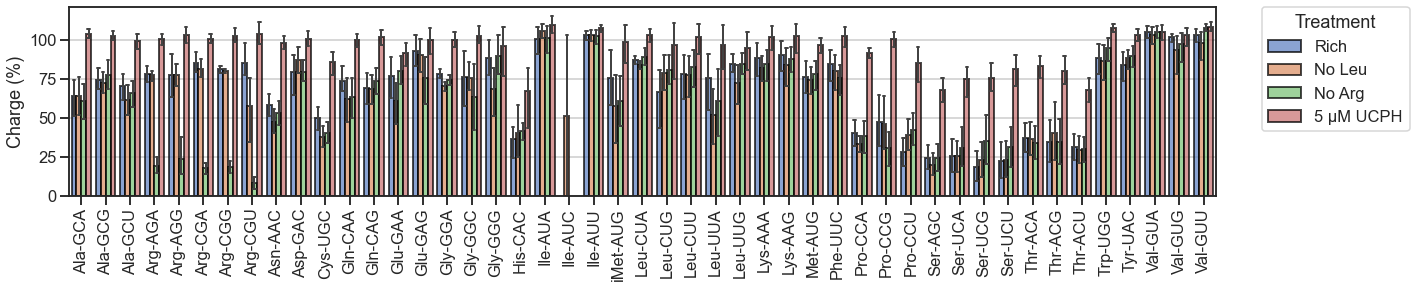

In [58]:
mask = (df_charge['human_codon']) & (~df_charge['mito_codon']) & (df_charge['barcode'] != 'l4')
codon_list = sorted(set(df_charge['AA_codon'][mask].values), key=str.casefold)

fig, ax1 = plt.subplots(1, 1, figsize=(20, 4.4))

g1 = sns.barplot(ax=ax1, x='AA_codon', y='charge_norm', hue='sample_name', order=codon_list, hue_order=['Rich', 'L', 'A', 'U'], data=df_charge[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
g1.grid(True, axis='y')
g1.set_ylabel('Charge (%)');
g1.set_xlabel('');
g1.set_xticklabels(g1.get_xticklabels(), rotation=90)

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = ['Rich', 'No Leu', 'No Arg', '5 μM UCPH']
title = 'Treatment'
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04,1), borderaxespad=0)


plt.tight_layout()
fig.savefig('mito.pdf')